In [10]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree as tr
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

In [11]:
def load_csvs_to_dfs(filenames):
    dataframes = []
    for name in filenames:
        file_path = f'../data/{name}.csv'
        try:
            df = pd.read_csv(file_path)
            dataframes.append(df)
            print(f'Loaded {file_path} into DataFrame: {name}')
        except FileNotFoundError:
            print(f'File {file_path} not found.')
    return dataframes

csvs = [
        'cesd_total', 
        'gad_total',
        'inq_perceivedburden',
        'inq_thwartedbelong',
        'upps_total']
dataframes = load_csvs_to_dfs(csvs)

Loaded ../data/cesd_total.csv into DataFrame: cesd_total
Loaded ../data/gad_total.csv into DataFrame: gad_total
Loaded ../data/inq_perceivedburden.csv into DataFrame: inq_perceivedburden
Loaded ../data/inq_thwartedbelong.csv into DataFrame: inq_thwartedbelong
Loaded ../data/upps_total.csv into DataFrame: upps_total


In [12]:
def plot_outcome(df: pd.DataFrame):
    # Extract the last column
    last_column_name = df.columns[-1]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.hist(df[last_column_name], bins=50)
    plt.title(f'Histogram of {last_column_name}')
    plt.ylabel(last_column_name)
    plt.grid(True)

    plt.savefig(f'../plots/hist_{last_column_name}.png')

In [13]:
def plot_correlations(df: pd.DataFrame):
    last_column_name = df.columns[-1]
    sns.clustermap(df.corr(), cmap='viridis')
    plt.savefig(f'../plots/corr_{last_column_name}.png')

In [14]:
def create_splits(df:pd.DataFrame):
    X = df.iloc[:,:-1].values
    y = df.iloc[:,-1].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size=0.15, 
        random_state=42)

    X_train, X_val, y_train, y_val = train_test_split(
        X_train, 
        y_train,
        test_size=X_test.shape[0] / X_train.shape[0],  
        random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [15]:
def identify_variable_types(data):
    continuous_vars = []
    dummy_vars = []

    num_columns = data.shape[1]
    
    for i in range(num_columns):
        unique_values = np.unique(data[:, i])
        if len(unique_values) == 2 and np.array_equal(unique_values, [0, 1]):
            dummy_vars.append(i)
        else:
            continuous_vars.append(i)
    
    return continuous_vars, dummy_vars

In [16]:
def transform_X(split):

    continuous_cols, dummy_cols = identify_variable_types(split)
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), continuous_cols),
            ('dummy', 'passthrough', dummy_cols)  # Leave dummy variables unchanged or use StandardScaler() if needed
        ]
    )
    split = preprocessor.fit_transform(split)

    return split

In [20]:
def loop_through_dfs(list_of_dfs):

    def run_on_splits(func):
        def _run_loop(*args, **kwargs):
            for x,y,nsplit in zip([X_train, X_val, X_test],
                                [y_train, y_val, y_test],
                                ['train', 'val', 'test']):
                func(*args, X=x, y=y, nsplit=nsplit, **kwargs)
        return _run_loop

    @run_on_splits
    def evaluate(model, X, y, nsplit, model_name, constant_value=None):
        ''' Evaluates the performance of a model 
        Args:
            model (sklearn.Estimator): fitted sklearn estimator
            X (np.array): predictors
            y (np.array): true outcome
            nsplit (str): name of the split
            model_name (str): string id of the model
            constant_value (int or None): relevant if the model predicts a constant
        '''
        if constant_value is not None:
            preds = np.array([constant_value] * y.shape[0])
        else:
            preds = model.predict(X)
        r2 = r2_score(y, preds)
        performance = np.sqrt(mean_squared_error(y, preds))
        model_performances.append({'model': model_name,
                            'split': nsplit,
                            'rmse': round(performance, 4),
                            'r2': round(r2, 4)})
    
    for idx, df in enumerate(list_of_dfs):
        
        # plot outcome variable
        #plot_outcome(df)

        # plot correlations
        #plot_correlations(df)

        # create splits
        X_train, X_val, X_test, y_train, y_val, y_test = create_splits(df)

        # transform X
        X_train = transform_X(X_train)
        X_val = transform_X(X_val)
        X_test = transform_X(X_test)
        
        model_performances = []

        # run null model
        evaluate(model=None, model_name='dummy', constant_value=y_train.mean())

        # run plain linear regression
        reg = LinearRegression().fit(X_train, y_train)
        evaluate(model=reg, model_name='linear')

        # run ridge and lasso versions
        models = {} 
        models['linear-0.0'] = reg
        for alpha in [0.01, 0.1, 0.2, 0.5, 1.0, 20.0, 10.0, 100.0, 1000.0]:
            for est in [Lasso, Ridge]:
                if est == Lasso:
                    id = 'lasso'
                else:
                    id = 'ridge'
                reg = est(alpha=alpha).fit(X_train, y_train)
                models[f'{id}-{alpha}'] = reg
                evaluate(model=reg, model_name=f'{id}-alpha-{alpha}')

        # run random forest regression
        rfreg = RandomForestRegressor(random_state=42)
        param_grid = { 
            'n_estimators': [10, 20, 100, 200, 500],
            'max_depth' : [2, 3, 5, 10],
            'min_samples_split': [2, 5, 10],
            'max_features': [0.3, 0.6, 0.9], # can you guess what this is, without looking at the documentation?
            'ccp_alpha': [0.01, 0.1, 1.0]
        }
        cv_rfr = RandomizedSearchCV(estimator=rfreg, # I am choosing RandomizedSearchCV for speed, but you can also go for GridSearchCV :)
                                    param_distributions=param_grid,
                                    scoring='neg_mean_squared_error', # this is "neg" because CV wants a metric to maximize
                                    n_iter=20, # this should more likely be above 100, and in general the higher the better
                                    cv=5)
        cv_rfr.fit(X_train, y_train)
        evaluate(model=cv_rfr.best_estimator_, model_name=f'random-forest')
        importances = cv_rfr.best_estimator_.feature_importances_
        feature_names = df.columns.tolist()[:-1]
        # Get the indices of the top 10 features based on their importances
        top_10_indices = np.argsort(importances)[-10:][::-1]

        # Select the top 10 feature names and their importances
        top_10_feature_names = [feature_names[i] for i in top_10_indices]
        top_10_importances = importances[top_10_indices]

        # Plot the top 10 feature importances using seaborn barplot
        plt.figure(figsize=(10, 8))
        sns.barplot(
            x=top_10_feature_names, 
            y=top_10_importances, 
            color=sns.color_palette()[0])
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.title('Top 10 Feature Importances')
        plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
        plt.savefig(f'../plots/features_rfreg_{idx}.png')

        # run xgboost regression
        xgbreg = XGBRegressor(random_state=42)

        param_grid = { 
            'n_estimators': [10, 20, 100, 200, 500],
            'max_depth' : [2, 3, 5, 10],
            'objective': ['reg:squarederror'],
            'colsample_bytree': [0.3, 0.6, 0.9],
            'learning_rate': [2e-5, 2e-4, 2e-3, 2e-2, 2e-1]
        }
        cv_xgb = RandomizedSearchCV(estimator=xgbreg, 
                                    param_distributions=param_grid,
                                    scoring='neg_mean_squared_error',
                                    n_iter=20, # this should be at least 100
                                    cv=5)
        cv_xgb.fit(X_train, y_train)
        evaluate(model=cv_xgb.best_estimator_, model_name=f'xgboost')
        importances = cv_xgb.best_estimator_.feature_importances_
        # Get the indices of the top 10 features based on their importances
        top_10_indices = np.argsort(importances)[-10:][::-1]

        # Select the top 10 feature names and their importances
        top_10_feature_names = [feature_names[i] for i in top_10_indices]
        top_10_importances = importances[top_10_indices]

        # Plot the top 10 feature importances using seaborn barplot
        plt.figure(figsize=(10, 8))
        sns.barplot(
            x=top_10_feature_names, 
            y=top_10_importances, 
            color=sns.color_palette()[0])
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.title('Top 10 Feature Importances')
        plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
        plt.savefig(f'../plots/features_xgb_{idx}.png')

        # check model performances
        perf_df = pd.DataFrame(model_performances)
        perf_df_filtered = perf_df[perf_df['model'] != 'linear']
        plt.figure(figsize=(10, 8))
        sns.scatterplot(data=perf_df_filtered.sort_values(by='rmse', ascending=False), 
                        y='model', 
                        x='rmse', 
                        marker='s', 
                        hue='split', palette=['darkorange', 'grey', 'darkred'])
        plt.savefig(f'../plots/model_perfs_{idx}.png')


/home/ucloud/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.271e+01, tolerance: 3.308e+00
  model = cd_fast.enet_coordinate_descent(
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.074e+02, tolerance: 9.889e+00
  model = cd_fast.enet_coordinate_descent(


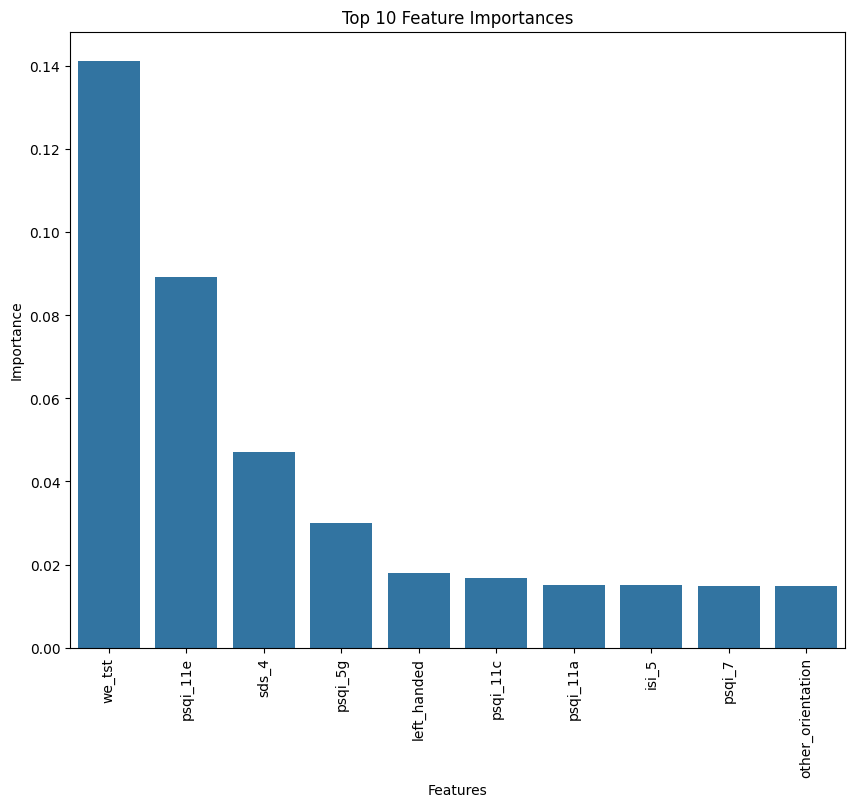

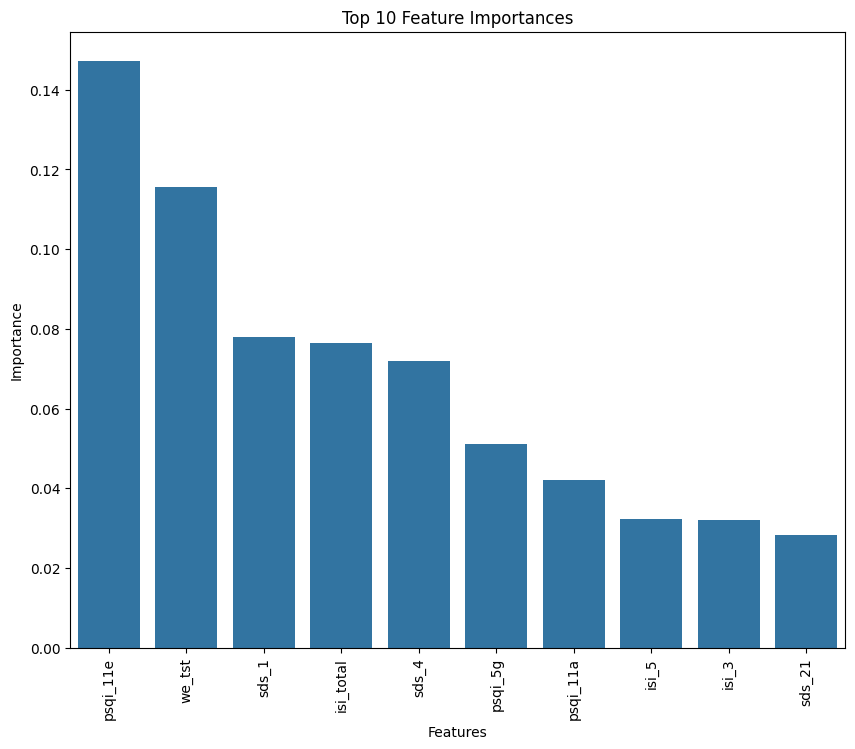

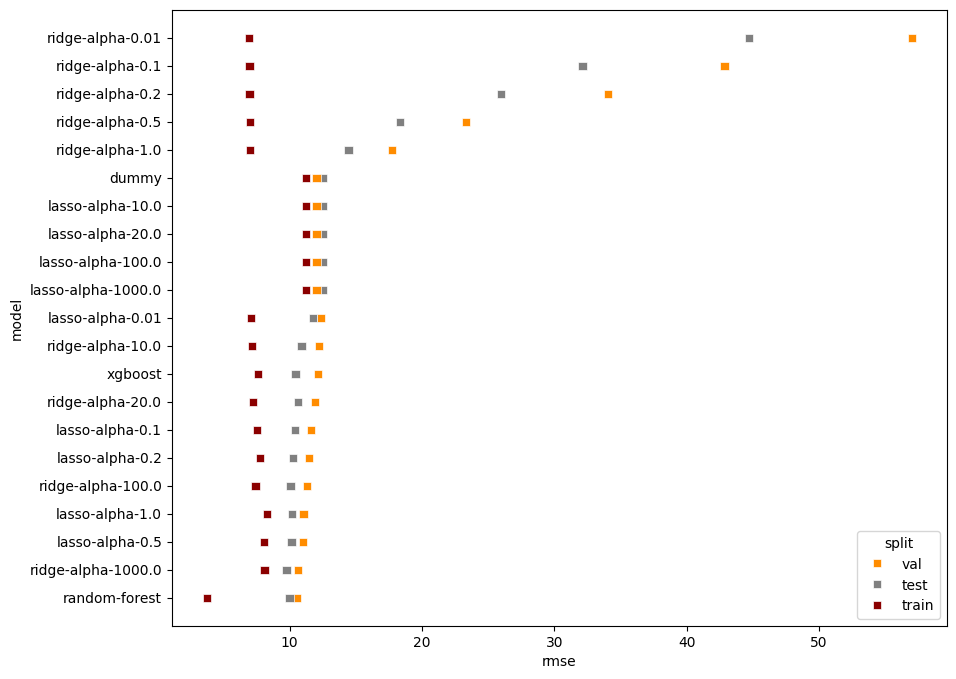

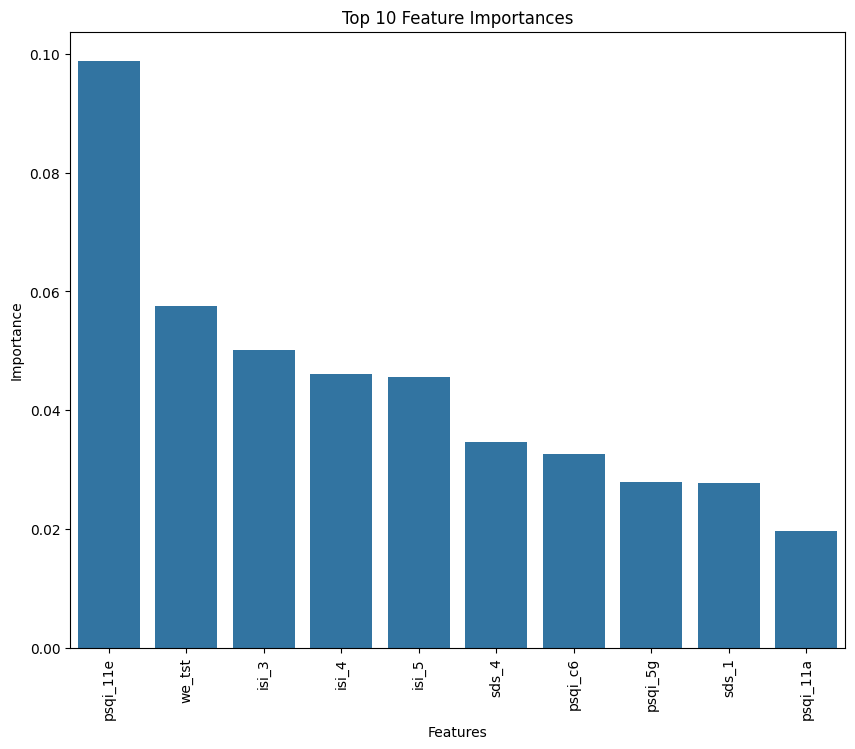

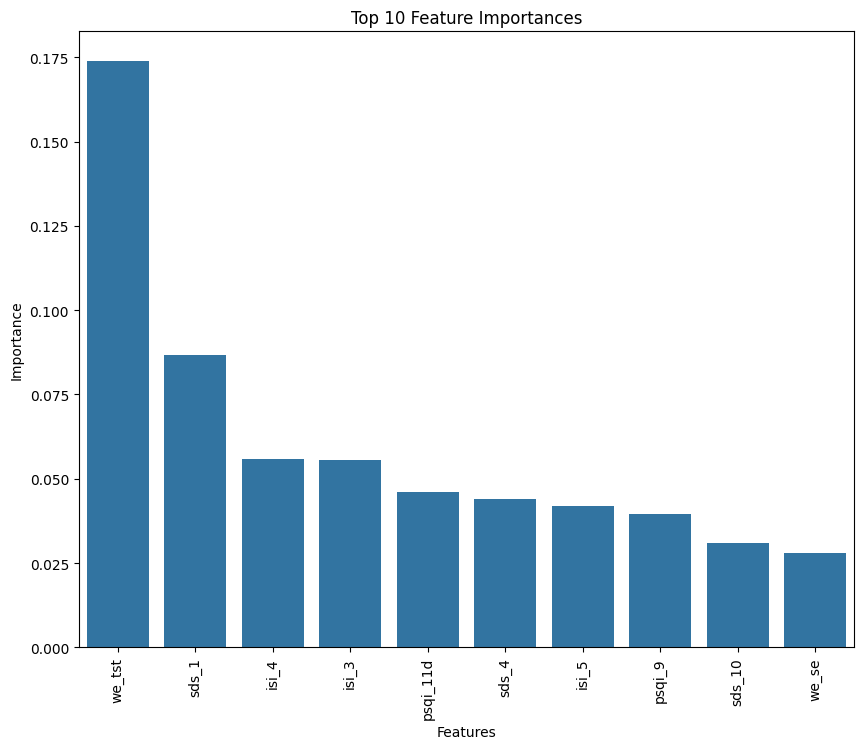

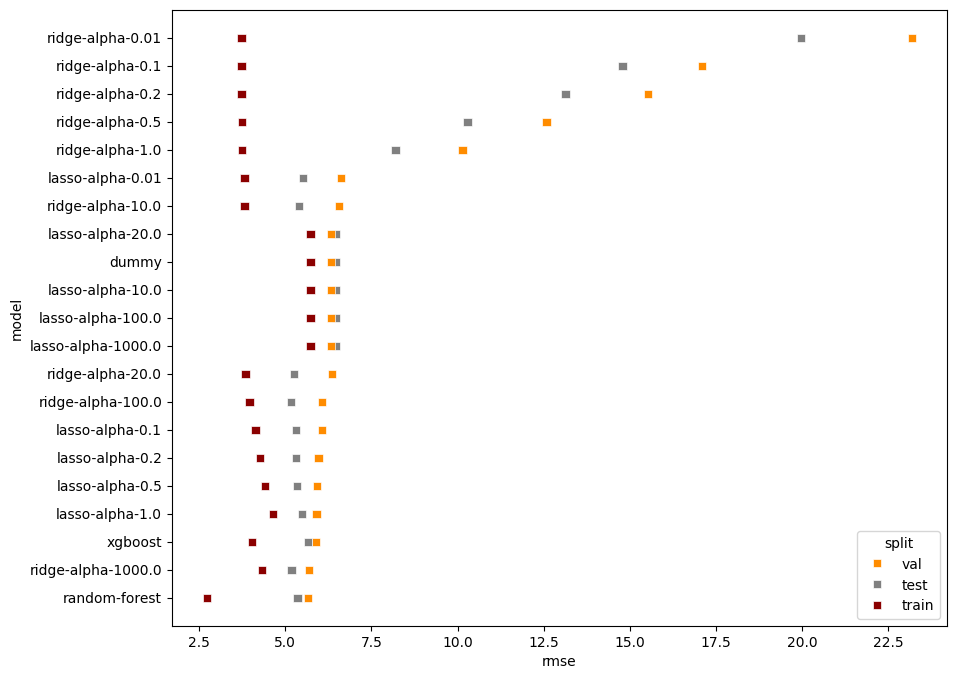

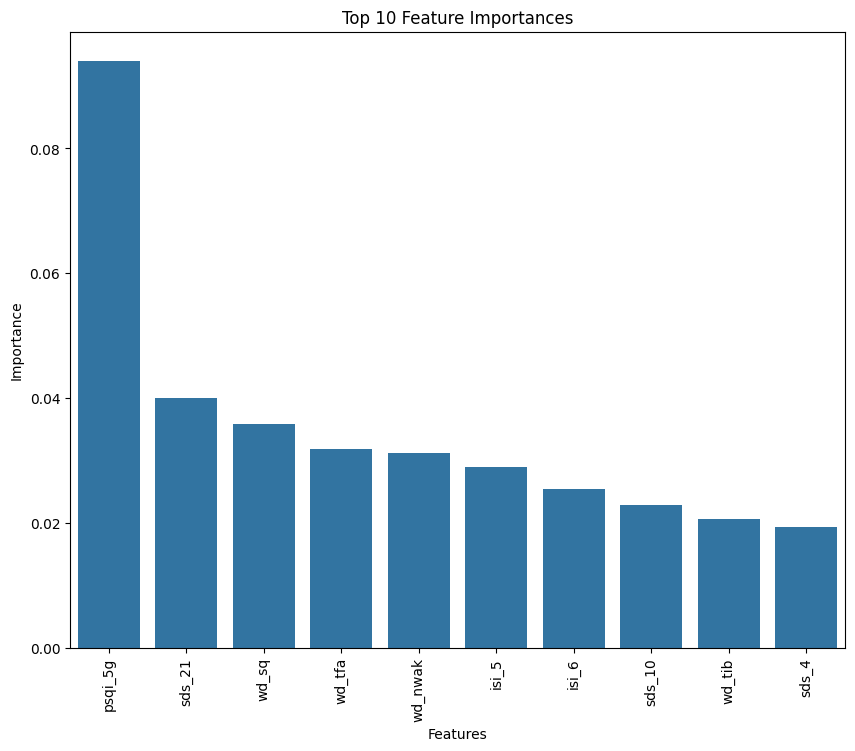

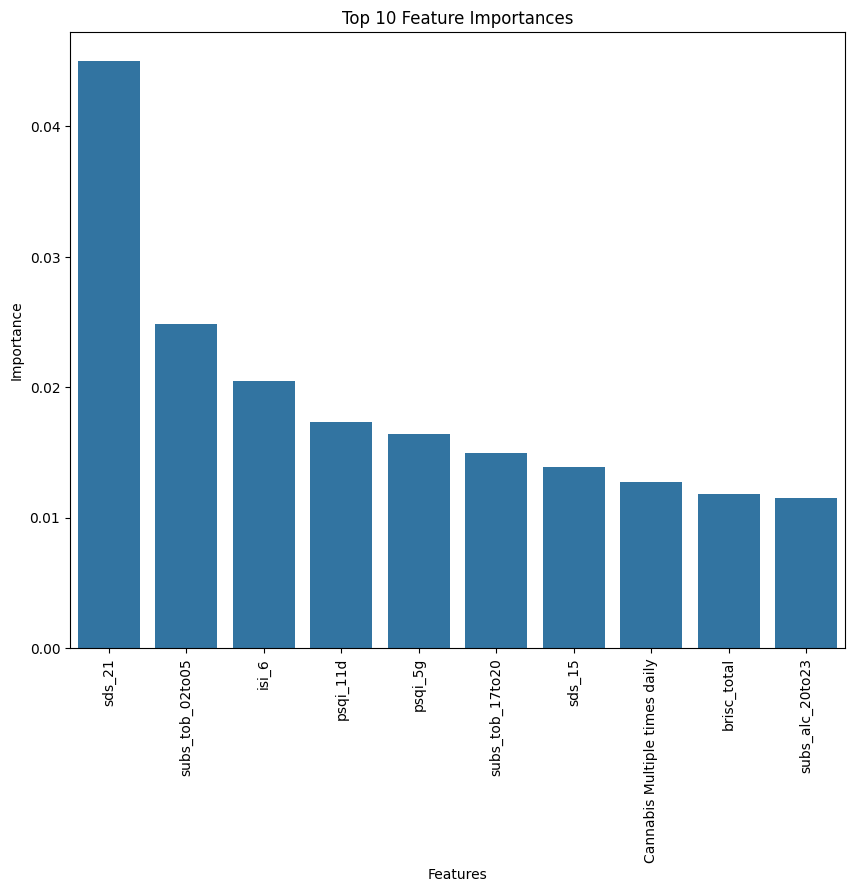

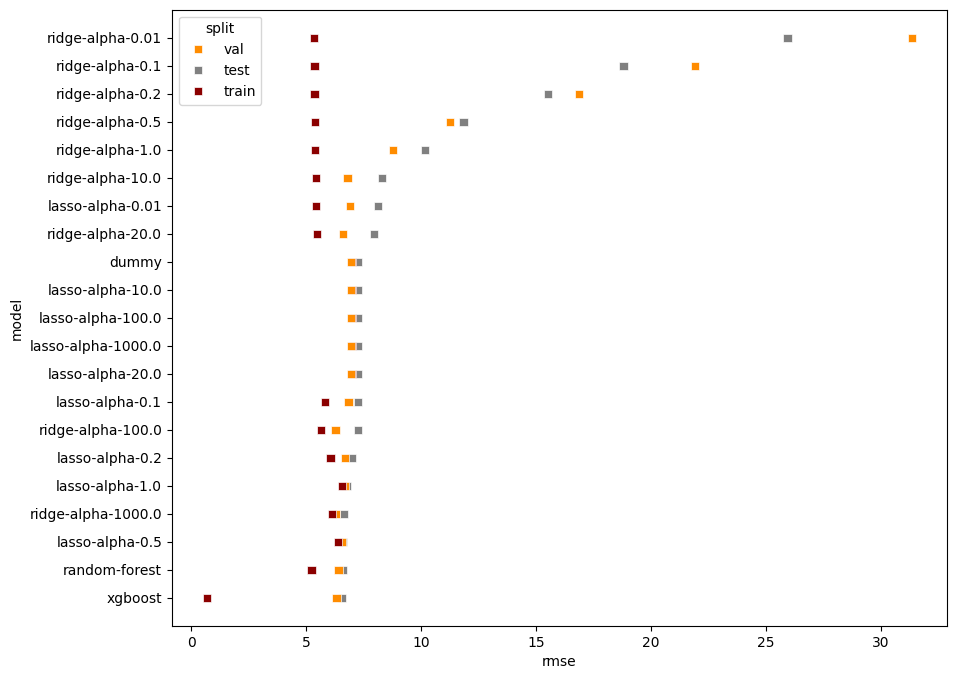

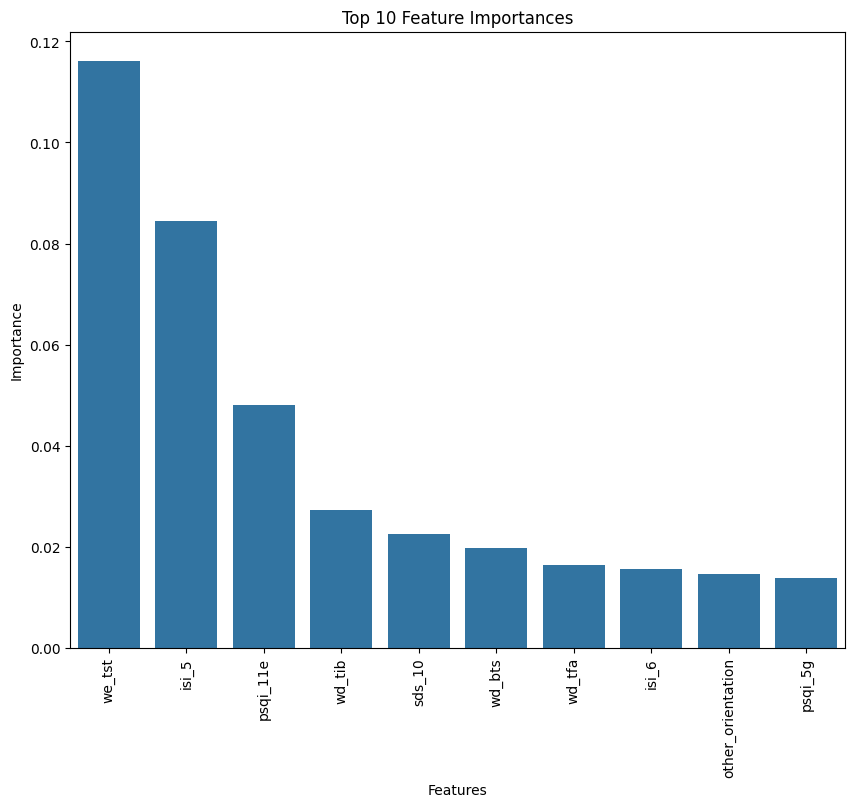

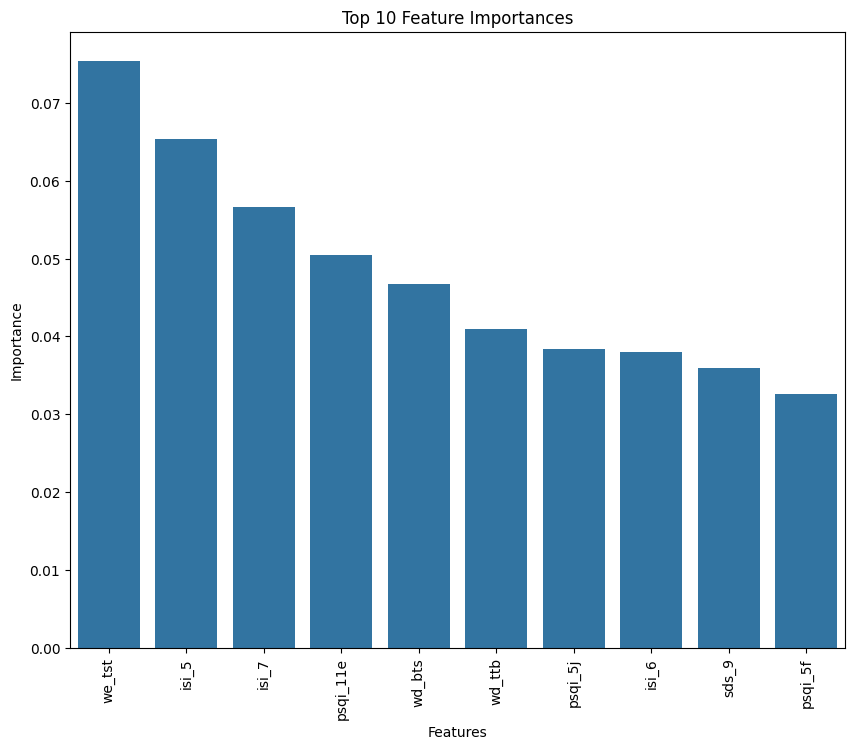

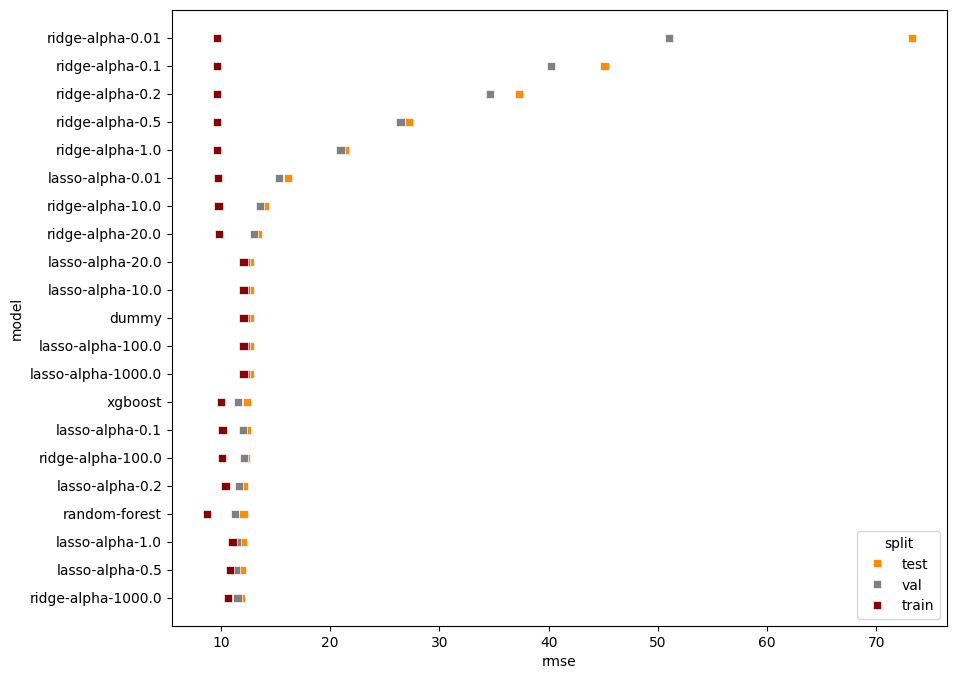

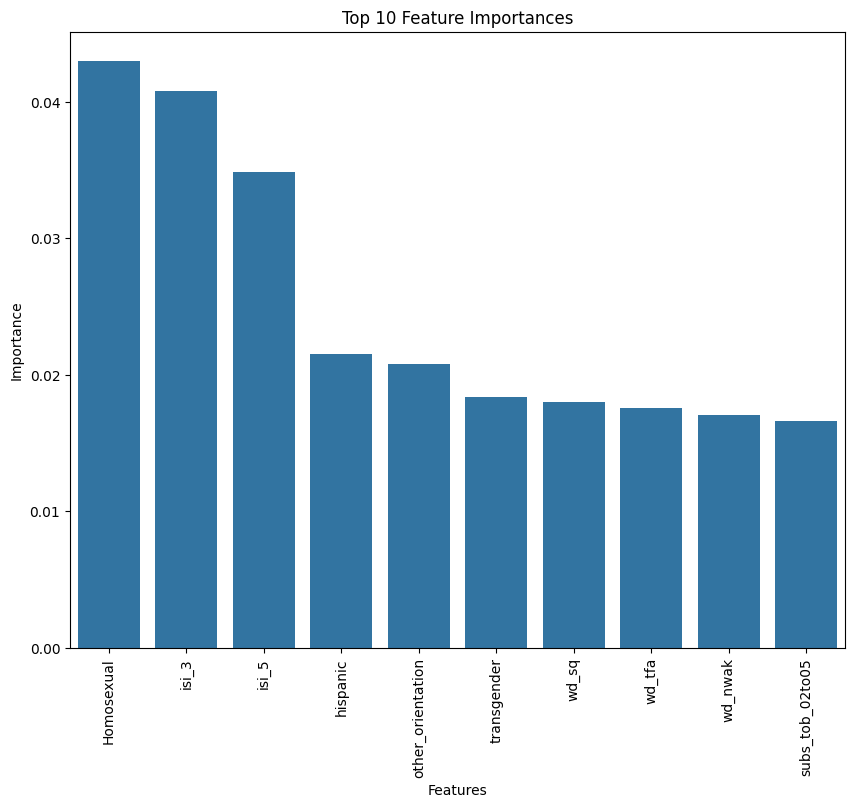

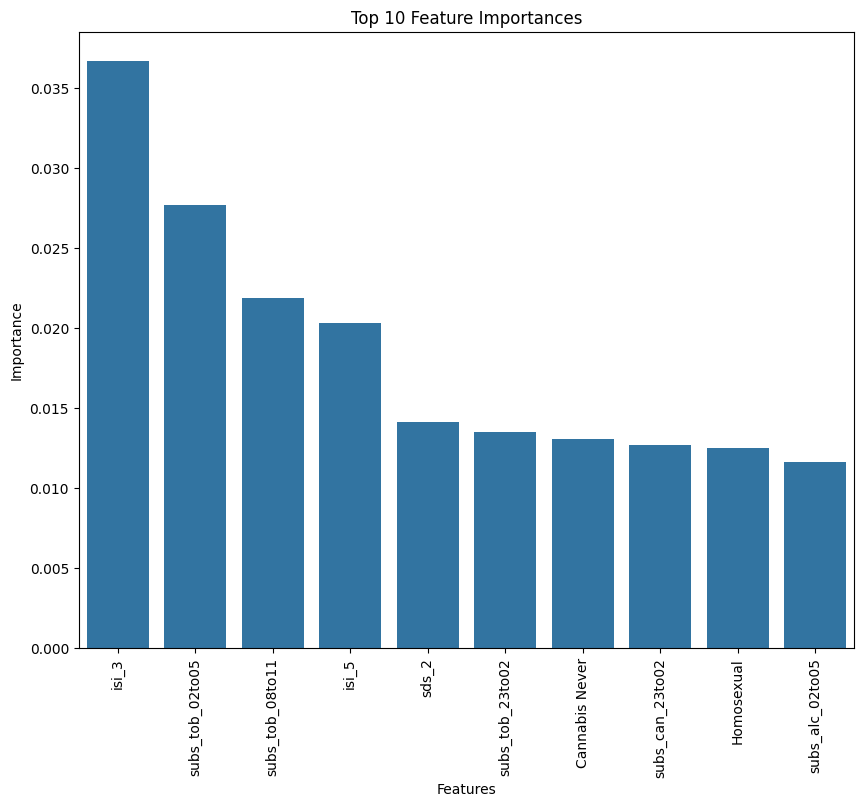

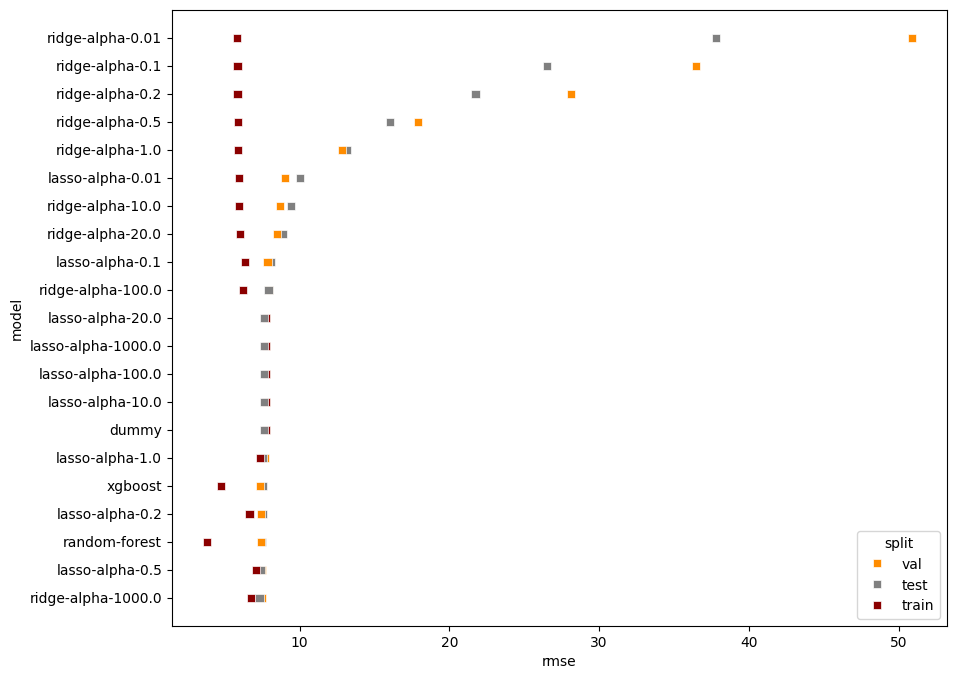

In [21]:
loop_through_dfs(dataframes)